# Описание проекта
Задание: помочь маркетологам оптимизировать маркетинговые затраты.
Имеющиеся данные :
лог сервера с данными о посещениях сайта,
выгрузка всех заказов за этот период,
статистика рекламных расходов.

Изучим:
* как люди пользуются продуктом,
* когда они начинают покупать,
* сколько денег приносит каждый клиент
* когда клиент окупается.

## Оглавление

* [Загрузка и подготовка данных](#Шаг_1)
* [Строим отчеты и считаем метрики](#Шаг_2)
* [Общий вывод](#Шаг_3)

<a id = 'Шаг_1' > </a> 
## Шаг 1. Загрузка и подготовка данных

In [1]:
#Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders =  pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [4]:
#Таблица посещений
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [6]:
visits.columns = ['device', 'end_ts', 'source_id','start_ts','uid']

In [7]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

In [8]:
visits.duplicated().sum()

0

##### Таблица visits (лог сервера с информацией о посещениях сайта):
* uid — уникальный идентификатор пользователя
* device — категория устройства пользователя
* start_ts — дата и время начала сессии
* end_ts — дата и время окончания сессии
* source_id — идентификатор рекламного источника, из которого пришел пользователь

In [9]:
# Таблица заказов
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [11]:
orders.columns = ['buy_ts', 'revenue','uid']
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [12]:
orders.duplicated().sum()

0

##### Таблица orders (информация о заказах):
* uid — уникальный id пользователя, который сделал заказ
* buy_ts — дата и время заказа
* revenue — выручка Яндекс.Афиши с этого заказа

In [13]:
# Таблица затрат на маркетинг
costs.tail()

,source_id,dt,costs
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15
2541,10,2018-05-31,17.60


In [14]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [15]:
costs['dt'] = pd.to_datetime(costs['dt'])

In [16]:
costs.duplicated().sum()

0

##### Таблица costs (информация о затратах на маркетинг):
* source_id — идентификатор рекламного источника
* dt — дата
* costs — затраты на этот рекламный источник в этот день

### Вывод

Загрузили данные, переименовали столбцы и привели к типу datetime нужные столбцы. Пропусков и дубликатов нет.
Данные готовы к анализу.

<a id = 'Шаг_2' > </a> 
## Шаг 2. Строим отчеты и считаем метрики.

##### Продукт
* Для начала рассмотрим сколько людей пользуются сайтом в день, неделю, месяц

Для этого необходимо рассчитать метрики DAU, WAU, MAU.

Добавим в датафрейм столбцы со значениями года, месяца, недели и точной даты посещения.

In [17]:
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week'] = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date

In [18]:
visits

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27
...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017,7,30,2017-07-29
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018,1,4,2018-01-25
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018,3,9,2018-03-03
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017,11,44,2017-11-02


Рассчитаем метрики.

In [19]:
# Будем выводить метрики dau, wau, mau для различных источников
for source in visits['source_id'].sort_values().unique():
    # Для расчета sticky factor
    update_visits = visits.query('source_id == @source')
    dau_total = update_visits.groupby('session_date').agg({'uid':'nunique'})
    wau_total = update_visits.groupby(['session_year', 'session_week']).agg({'uid':'nunique'})
    mau_total = update_visits.groupby(['session_year', 'session_month']).agg({'uid':'nunique'})   
    # Разделим по девайсам
    update_visits_mobile = update_visits.query('device == "touch"')
    update_visits_deskt = update_visits.query('device == "desktop"')
    dau_total_mobile = update_visits_mobile.groupby('session_date').agg({'uid':'nunique'})
    dau_total_deskt = update_visits_deskt.groupby('session_date').agg({'uid':'nunique'})
    wau_total_mobile = update_visits_mobile.groupby(['session_year', 'session_week']).agg({'uid':'nunique'})
    wau_total_deskt = update_visits_deskt.groupby(['session_year', 'session_week']).agg({'uid':'nunique'})
    mau_total_mobile = update_visits_mobile.groupby(['session_year', 'session_month']).agg({'uid':'nunique'})
    mau_total_deskt = update_visits_deskt.groupby(['session_year', 'session_month']).agg({'uid':'nunique'})
    sticky_fac_wau = (dau_total.mean() / wau_total.mean())  
    sticky_fac_mau = (dau_total.mean() / mau_total.mean()) 
    print('Источник:', source)
    print('В среднем в день сервисом пользуются {} человек, заходящих с компьютера'.format(int(dau_total_deskt.mean())))
    print('В среднем в день сервисом пользуются {} человек, заходящих с мобильных девайсов'.format(int(dau_total_mobile.mean())))
    print()
    print('В среднем в неделю сервисом пользуются {} человек, заходящих с компьютера'.format(int(wau_total_deskt.mean())))
    print('В среднем в неделю сервисом пользуются {} человек, заходящих с мобильных девайсов'.format(int(wau_total_mobile.mean())))
    print()
    print('В среднем в месяц сервисом пользуются {} человек, заходящих с компьютера'.format(int(mau_total_deskt.mean())))
    print('В среднем в месяц сервисом пользуются {} человек, заходящих с мобильных девайсов'.format(int(mau_total_mobile.mean())))
    print('sticky factor(неделя): {:.2%}'.format(float(sticky_fac_wau)))
    print('sticky factor(месяц): {:.2%}'.format(float(sticky_fac_mau)))
    
    print()

Источник: 1
В среднем в день сервисом пользуются 59 человек, заходящих с компьютера
В среднем в день сервисом пользуются 20 человек, заходящих с мобильных девайсов

В среднем в неделю сервисом пользуются 334 человек, заходящих с компьютера
В среднем в неделю сервисом пользуются 131 человек, заходящих с мобильных девайсов

В среднем в месяц сервисом пользуются 1284 человек, заходящих с компьютера
В среднем в месяц сервисом пользуются 547 человек, заходящих с мобильных девайсов
sticky factor(неделя): 17.38%
sticky factor(месяц): 4.43%

Источник: 2
В среднем в день сервисом пользуются 89 человек, заходящих с компьютера
В среднем в день сервисом пользуются 31 человек, заходящих с мобильных девайсов

В среднем в неделю сервисом пользуются 522 человек, заходящих с компьютера
В среднем в неделю сервисом пользуются 198 человек, заходящих с мобильных девайсов

В среднем в месяц сервисом пользуются 1965 человек, заходящих с компьютера
В среднем в месяц сервисом пользуются 820 человек, заходящих 

Исходя из полученных результатов, можем исключить из анализа источники 6 и 7. Наилучшие результаты показывают источники 1,2 и 10.
Построим графики изменения количества пользователей по месяцам для разных источников.
Sticky factor по всем источникам показывает достаточно низкие результаты. Тем не менее для информационного портала нет необходиомсти удерживать пользователей, как в играх, поэтому, результат вероятно адекватный.
https://ru.wikipedia.org/wiki/Sticky_Factor

In [20]:
visits_plot = visits.query('source_id in [1,2,3,4,5,9,10]')

In [21]:
visits_plot['session_month'] = visits_plot['session_date'].astype('datetime64[M]')

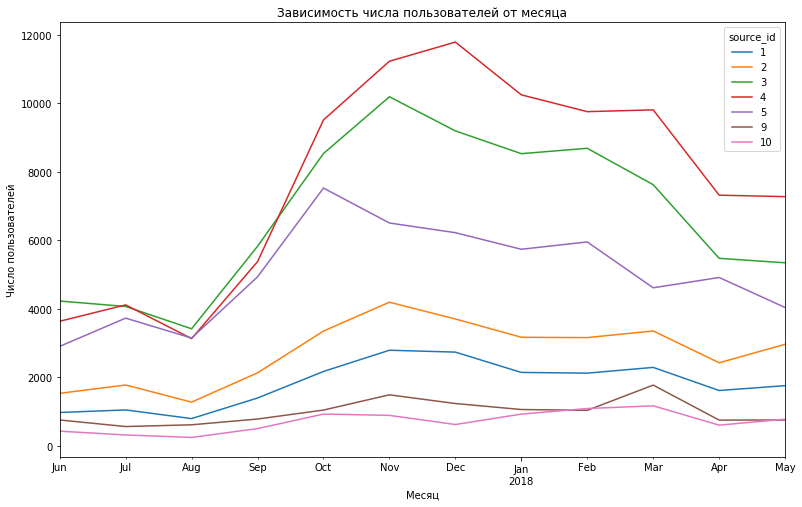

In [22]:
final_plot = visits_plot.pivot_table(index ='session_month', 
                               columns = 'source_id', values = 'uid', 
                               aggfunc = 'nunique').plot(figsize = (13,8))
final_plot.set_xlabel('Месяц')
final_plot.set_ylabel('Число пользователей')
plt.title('Зависимость числа пользователей от месяца')              
plt.show()

Из графика видим, что исторически наибольшее число пользователей приходило из 3, 4, 5 рекламных источников. Так же неплохие результаты показывал 2 источник, при этом он находился на момент конца наблюдений на подъеме, несмотря на общий спад.

* Рассмотрим пользовательские сессии

Для начала рассмотрим число сессий в день

In [23]:
sessions_per_user = visits.groupby(['session_date','session_month']).agg({'uid':['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
print(sessions_per_user) 

                            n_sessions  n_users  sessions_per_user
session_date session_month                                        
2017-06-01   6                     664      605           1.097521
2017-06-02   6                     658      608           1.082237
2017-06-03   6                     477      445           1.071910
2017-06-04   6                     510      476           1.071429
2017-06-05   6                     893      820           1.089024
...                                ...      ...                ...
2018-05-27   5                     672      620           1.083871
2018-05-28   5                    1156     1039           1.112608
2018-05-29   5                    1035      948           1.091772
2018-05-30   5                    1410     1289           1.093871
2018-05-31   5                    2256     1997           1.129695

[364 rows x 3 columns]


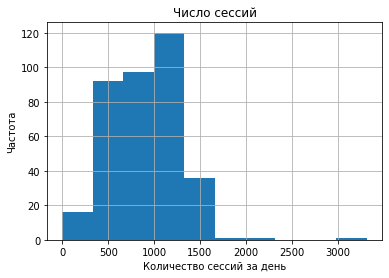

In [24]:
plot = sessions_per_user['n_users'].hist()
plt.title('Число сессий')
plot.set_xlabel('Количество сессий за день')
plot.set_ylabel('Частота')
plt.show()

In [25]:
sessions_per_user['n_users'].median()

921.0

In [26]:
sessions_per_user[(sessions_per_user['n_users'] < 100) | (sessions_per_user['n_users'] > 2500)]['n_users']

session_date  session_month
2017-11-24    11               3319
2018-03-31    3                   1
Name: n_users, dtype: int64

Среднестатистически в день проходит 921 сессия, при этом есть выбросы, например, 3319 или 1.
Они объясняются, возможно, какой-либо технической ошибкой.
При этом на каждого пользователя приходится чуть больше одной сессии. Возможно, некоторые пользователя перепроверяют информацию в течение дня.

Рассчитаем среднюю продолжительность сессии.

In [27]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['session_duration_sec'].mean()

643.506488592098

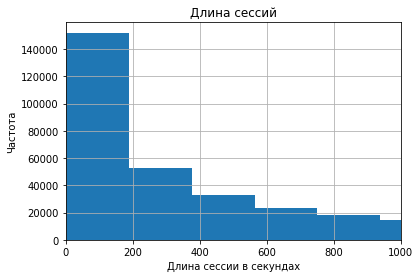

In [28]:
plt.title('Длина сессий')
plot = visits['session_duration_sec'].hist(bins = 450)
plot.set_xlim([0,1000])
plot.set_xlabel('Длина сессии в секундах')
plot.set_ylabel('Частота')
plt.show()

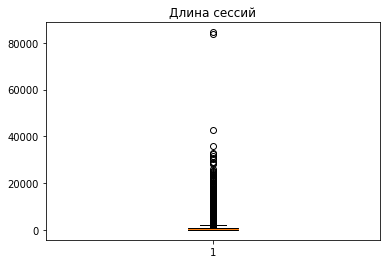

In [29]:
plt.title('Длина сессий')
plt.boxplot(visits['session_duration_sec'])
plt.show()

Посчитаем моду времени сессии, поскольку распределение не нормальное.

In [30]:
asl = visits['session_duration_sec'].mode()
asl

0    60
dtype: int64

* Рассчитаем retention rate, с помощью когортного анализа.

Построим когорты по месяцам.

In [31]:
first_activity_date = visits.groupby('uid')['start_ts'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.join(first_activity_date, on = 'uid')
visits

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec,first_activity_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-09 20:05:00
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0,2017-12-27 14:06:00
...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017,7,30,2017-07-29,19,2017-07-29 19:07:00
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018,1,4,2018-01-25,19,2018-01-25 17:38:00
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018,3,9,2018-03-03,19,2018-03-03 10:12:00
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017,11,44,2017-11-02,19,2017-11-02 10:12:00


In [32]:
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')

In [33]:
visits['session_month'] = visits['session_date'].astype('datetime64[M]')

In [34]:
visits['cohort_lifetime'] = visits['session_month'] - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype(int)

In [35]:
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 
cohorts

,first_activity_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


Найдём исходное количество пользователей в когорте.

In [36]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 

In [37]:
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')
cohorts

,first_activity_month,cohort_lifetime,uid,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259
...,...,...,...,...
73,2018-03-01,1,861,20589
74,2018-03-01,2,557,20589
75,2018-04-01,0,15709,15709
76,2018-04-01,1,760,15709


Рассчитаем Retention Rate. Разделим количество активных пользователей в каждый из месяцов на исходное число пользователей в когорте.

In [38]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

In [39]:
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',
                                      values='retention',aggfunc='sum')
#Удалим столбец первого месяца, в который retention rate = 100%, для лучшей визуализации
retention_pivot = retention_pivot.drop(columns = 0)

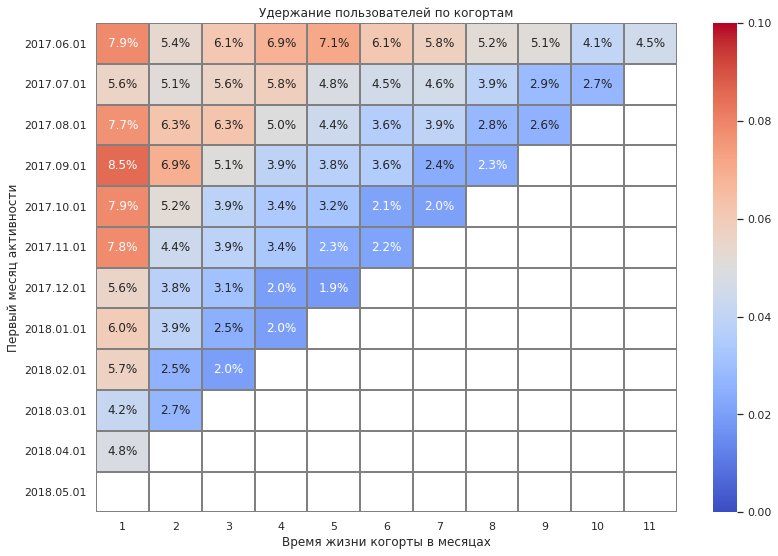

In [40]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Удержание пользователей по когортам')
plot = sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin = 0, vmax = 0.1, 
            cmap = 'coolwarm', yticklabels=retention_pivot.index.strftime('%Y.%m.%d'))
plot.set_xlabel('Время жизни когорты в месяцах')
plot.set_ylabel('Первый месяц активности')
plt.show()

Видим, что лучше всего retention rate сохранялся в первой когорте. С каждой последующей когортой период перед сильным падением уменьшается. Если для первой когорты(июнь 2017) разница в три процента была достигнута только к 8-му месяцу, то, например, для 5-й(октябрь 2017) когорты расхождение в 3 процента достигается уже ко второму месяцу.
Возможной причиной является большое количество сервисов по продаже билетов на различные мероприятия.
Возможно со временем были внедрены неудобные нововведения, либо упало качество работы службы поддержки, так же возможно  были выбраны неэффективные источники трафика в июле 2017 и декабре - апреле 2018, поскольку там удержание пользователей в первый месяц уступает значению на половине времени жизни первой когорты.

##### Продажи

* Когда люди начинают покупать?

Рассчитаем время от первой сессии до первой покупки.

Добавим в таблицу orders дату первой активности и дату первой покупки.

In [41]:
orders = orders.join(first_activity_date, on = 'uid')
orders

,buy_ts,revenue,uid,first_activity_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00
...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 09:11:00
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:05:00
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:52:00
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2017-10-23 12:32:00


In [42]:
first_buy = orders.groupby('uid')['buy_ts'].min()
first_buy.name = 'first_buy'
orders = orders.join(first_buy, on = 'uid')
orders

,buy_ts,revenue,uid,first_activity_date,first_buy
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,2017-06-01 07:58:00
...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 09:11:00,2018-05-31 23:50:00
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:05:00,2018-05-31 23:50:00
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:52:00,2018-05-31 23:54:00
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2017-10-23 12:32:00,2018-05-31 23:56:00


Теперь вычтем из даты покупки дату первой сессии и получим время в секундах.

In [43]:
orders['seconds_before_purchase'] = orders['first_buy'] - orders['first_activity_date']
orders['seconds_before_purchase'] = orders['seconds_before_purchase'] / np.timedelta64(1, 's')
orders['seconds_before_purchase'] = orders['seconds_before_purchase'].round().astype(int)
orders

,buy_ts,revenue,uid,first_activity_date,first_buy,seconds_before_purchase
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01 00:10:00,60
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01 00:25:00,660
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2017-06-01 00:27:00,120
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2017-06-01 00:29:00,900
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,2017-06-01 07:58:00,1620
...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 09:11:00,2018-05-31 23:50:00,52740
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:05:00,2018-05-31 23:50:00,2700
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:52:00,2018-05-31 23:54:00,120
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2017-10-23 12:32:00,2018-05-31 23:56:00,19049040


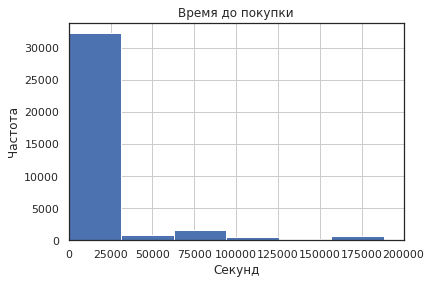

In [44]:
plot = orders['seconds_before_purchase'].hist(bins = 1000)
plt.title('Время до покупки')
plt.xlabel('Секунд')
plt.ylabel('Частота')
plot.set_xlim([0,200000])
plt.show()

In [45]:
orders['seconds_before_purchase'].median()

1320.0

Медианное значение времени до первой покупки 1320 секунд. То есть в среднем пользователям для совершения покупки нужно около 20 минут. Ранее высказанная гипотеза о том, что среднестатистическая сессия коротка для совершения покупки подтверждается.

* Посчитаем количество покупок за месяц.

In [46]:
orders

,buy_ts,revenue,uid,first_activity_date,first_buy,seconds_before_purchase
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01 00:10:00,60
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01 00:25:00,660
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2017-06-01 00:27:00,120
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2017-06-01 00:29:00,900
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,2017-06-01 07:58:00,1620
...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 09:11:00,2018-05-31 23:50:00,52740
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:05:00,2018-05-31 23:50:00,2700
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:52:00,2018-05-31 23:54:00,120
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2017-10-23 12:32:00,2018-05-31 23:56:00,19049040


In [47]:
orders['buy_year'] = orders['buy_ts'].dt.year
orders['buy_month'] = orders['buy_ts'].dt.month

In [48]:
merged_orders = visits.merge(orders, on = 'uid')
merged_orders

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec,first_activity_date_x,first_activity_month,cohort_lifetime,buy_ts,revenue,first_activity_date_y,first_buy,seconds_before_purchase,buy_year,buy_month
0,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,20,2018-05-20,1440,2018-03-09 20:05:00,2018-03-01,2,2018-03-09 20:25:00,2.33,2018-03-09 20:05:00,2018-03-09 20:25:00,1200,2018,3
1,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,2018-03-01,10,2018-03-09,1680,2018-03-09 20:05:00,2018-03-01,0,2018-03-09 20:25:00,2.33,2018-03-09 20:05:00,2018-03-09 20:25:00,1200,2018,3
2,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,2017-09-01,35,2017-09-03,60,2017-09-03 21:35:00,2017-09-01,0,2017-09-04 12:46:00,2.44,2017-09-03 21:35:00,2017-09-04 12:46:00,54660,2017,9
3,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,2017-09-01,35,2017-09-03,60,2017-09-03 21:35:00,2017-09-01,0,2017-10-28 00:01:00,1.53,2017-09-03 21:35:00,2017-09-04 12:46:00,54660,2017,10
4,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,2017-09-01,35,2017-09-03,60,2017-09-03 21:35:00,2017-09-01,0,2017-10-28 19:16:00,1.53,2017-09-03 21:35:00,2017-09-04 12:46:00,54660,2017,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761802,desktop,2017-12-04 12:50:00,3,2017-12-04 12:42:00,6752020629696526518,2017,2017-12-01,49,2017-12-04,480,2017-12-04 12:42:00,2017-12-01,0,2017-12-04 12:46:00,4.15,2017-12-04 12:42:00,2017-12-04 12:46:00,240,2017,12
761803,desktop,2017-11-20 23:44:00,4,2017-11-20 23:33:00,11750532881998794555,2017,2017-11-01,47,2017-11-20,660,2017-11-20 23:33:00,2017-11-01,0,2017-11-20 23:43:00,3.67,2017-11-20 23:33:00,2017-11-20 23:43:00,600,2017,11
761804,touch,2017-11-29 20:48:00,4,2017-11-29 20:27:00,11202626539189016002,2017,2017-11-01,48,2017-11-29,1260,2017-11-29 20:27:00,2017-11-01,0,2017-11-29 20:33:00,3.05,2017-11-29 20:27:00,2017-11-29 20:33:00,360,2017,11
761805,desktop,2018-04-23 21:19:00,10,2018-04-23 21:11:00,12734910664455613822,2018,2018-04-01,17,2018-04-23,480,2018-04-23 21:11:00,2018-04-01,0,2018-04-23 21:16:00,0.49,2018-04-23 21:11:00,2018-04-23 21:16:00,300,2018,4


In [49]:
for source in merged_orders['source_id'].sort_values().unique():
    if source != 7 :
        update_orders_mobile = merged_orders.query('source_id == @source & device == "touch"')
        update_orders_deskt = merged_orders.query('source_id == @source & device == "desktop"')
        month_purchases_mobile = update_orders_mobile.groupby(['buy_year', 'buy_month']).agg({'uid':'nunique'})
        month_purchases_deskt = update_orders_deskt.groupby(['buy_year', 'buy_month']).agg({'uid':'nunique'})
        print('Источник:', source)
        print('Среднее количество покупок на мобильных устройствах: {} '.format(int(month_purchases_mobile.mean().round())))
        print('Среднее количество покупок на компьютерах: {} '.format(int(month_purchases_deskt.mean().round())))
        print()

Источник: 1
Среднее количество покупок на мобильных устройствах: 185 
Среднее количество покупок на компьютерах: 608 

Источник: 2
Среднее количество покупок на мобильных устройствах: 212 
Среднее количество покупок на компьютерах: 638 

Источник: 3
Среднее количество покупок на мобильных устройствах: 266 
Среднее количество покупок на компьютерах: 1160 

Источник: 4
Среднее количество покупок на мобильных устройствах: 360 
Среднее количество покупок на компьютерах: 1031 

Источник: 5
Среднее количество покупок на мобильных устройствах: 184 
Среднее количество покупок на компьютерах: 853 

Источник: 9
Среднее количество покупок на мобильных устройствах: 68 
Среднее количество покупок на компьютерах: 254 

Источник: 10
Среднее количество покупок на мобильных устройствах: 38 
Среднее количество покупок на компьютерах: 136 



Видно, что покупки совершаются в основном с компьютеров. При этом больше всего покупают люди пришедшие из 3-го источника(компьютеры) - 1160 раз за месяц и из 4-го источника(мобильные устройства) - 360 раз за месяц. Это закономерно, поскольку из 3 и 4 источников приходит больше всего пользователей.
1,2 и 5 источники так же выглядят перспективно с точки зрения привлечения, поскольку достаточно большая часть от пришедших пользователей совершает покупки.

* Средний чек

In [50]:
orders['month'] = orders['buy_ts'].astype('datetime64[M]')
orders

,buy_ts,revenue,uid,first_activity_date,first_buy,seconds_before_purchase,buy_year,buy_month,month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01 00:10:00,60,2017,6,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01 00:25:00,660,2017,6,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2017-06-01 00:27:00,120,2017,6,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2017-06-01 00:29:00,900,2017,6,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,2017-06-01 07:58:00,1620,2017,6,2017-06-01
...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 09:11:00,2018-05-31 23:50:00,52740,2018,5,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:05:00,2018-05-31 23:50:00,2700,2018,5,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:52:00,2018-05-31 23:54:00,120,2018,5,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2017-10-23 12:32:00,2018-05-31 23:56:00,19049040,2018,5,2018-05-01


In [51]:
orders_grouped = orders.groupby(['month','uid',]).agg({'revenue':['sum','count']}).reset_index()
orders_grouped.columns = ['month','uid','sum_revenue','count']
orders_grouped['average_check'] = orders_grouped['sum_revenue'] / orders_grouped['count']
orders_grouped = orders_grouped.query('month < "2018-06-01"')


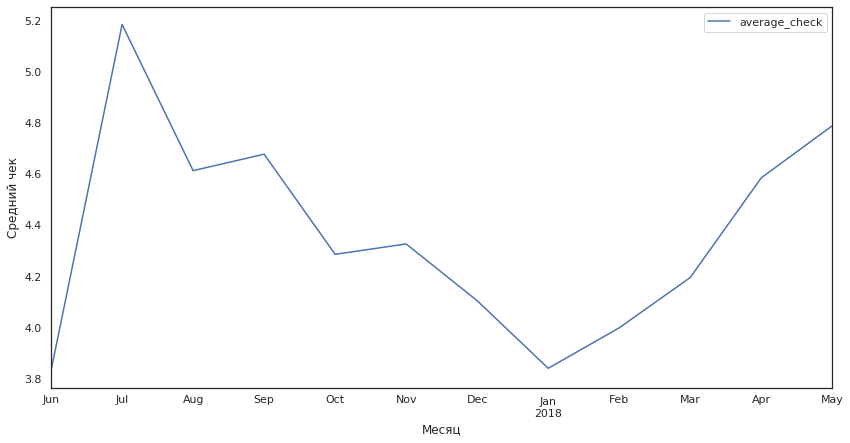

In [52]:
plot = orders_grouped.pivot_table(index = 'month',values = 'average_check').plot(figsize = (14,7))
plot.set_xlabel('Месяц')
plot.set_ylabel('Средний чек')
plt.show()

In [53]:
# Средний чек
orders_grouped['average_check'].mean().round(2)

4.31

In [54]:
# Среднее число покупок
orders_grouped['count'].mean().round(2)

1.23

Среднее значение метрики средний чек = 4.31. По графику видим, что самый высокий средний чек наблюдался в июле 2017 года. Начиная с этого месяца средний чек падал, несмотря на рост числа пользователей, вероятно покупка была неудобна, либо ассортимент был слишком маленьким для увеличивающегося пользовательского потока, при этом в 2018 году чек начал увеличиваться и почти достиг пиковых значений 2017 года. Возможно были успешно введены какие-либо акции, увеличился ассортимент, повысились цены в целом, либо покупка стала удобнее.

Так же в среднем пользователи совершают покупки чуть чаще 1 раза. Благодаря этому, можно сказать, что экономика одной продажи вероятно будет достаточно объективно отражать ситуацию.

* Рассчитаем LTV

Разделим покупателей на месячные когорты.

In [55]:
orders

,buy_ts,revenue,uid,first_activity_date,first_buy,seconds_before_purchase,buy_year,buy_month,month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01 00:10:00,60,2017,6,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01 00:25:00,660,2017,6,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2017-06-01 00:27:00,120,2017,6,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2017-06-01 00:29:00,900,2017,6,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,2017-06-01 07:58:00,1620,2017,6,2017-06-01
...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 09:11:00,2018-05-31 23:50:00,52740,2018,5,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:05:00,2018-05-31 23:50:00,2700,2018,5,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:52:00,2018-05-31 23:54:00,120,2018,5,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2017-10-23 12:32:00,2018-05-31 23:56:00,19049040,2018,5,2018-05-01


In [56]:
# Получим месяц первой покупки
first_orders = orders.groupby('uid').agg({'month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
print(first_orders.head()) 

                uid first_order_month
0   313578113262317        2018-01-01
1  1575281904278712        2017-06-01
2  2429014661409475        2017-10-01
3  2464366381792757        2018-01-01
4  2551852515556206        2017-11-01


In [57]:
# Считаем количество новых покупателей за калждый месяц
cohort_sizes2 = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes2.columns = ['first_order_month', 'n_buyers']
print(cohort_sizes2.head()) 

  first_order_month  n_buyers
0        2017-06-01      2023
1        2017-07-01      1923
2        2017-08-01      1370
3        2017-09-01      2581
4        2017-10-01      4340


Построим когорты. Добавим месяц первой покупки каждого покупателя в таблицу с заказами

In [58]:
orders_new = pd.merge(orders,first_orders, on='uid')
orders_new.head()

,buy_ts,revenue,uid,first_activity_date,first_buy,seconds_before_purchase,buy_year,buy_month,month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01 00:10:00,60,2017,6,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01 00:25:00,660,2017,6,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2017-06-01 00:27:00,120,2017,6,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2017-06-01 00:29:00,900,2017,6,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,2017-06-01 07:58:00,1620,2017,6,2017-06-01,2017-06-01


In [59]:
cohorts2 = orders_new.groupby(['first_order_month','month']).agg({'revenue': 'sum'}).reset_index()
cohorts2.head()

,first_order_month,month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [60]:
report = pd.merge(cohort_sizes2, cohorts2, on='first_order_month')
report

,first_order_month,n_buyers,month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58
...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87
75,2018-04-01,2276,2018-04-01,10600.69
76,2018-04-01,2276,2018-05-01,1209.92
77,2018-05-01,2988,2018-05-01,13925.76


In [61]:
# Поскольку маржинальность неизвестна, возьмем за 1
margin_rate = 1
    
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report = report.query('age < 7')
print(report.head()) 

  first_order_month  n_buyers      month  revenue       gp  age
0        2017-06-01      2023 2017-06-01  9557.49  9557.49    0
1        2017-06-01      2023 2017-07-01   981.82   981.82    1
2        2017-06-01      2023 2017-08-01   885.34   885.34    2
3        2017-06-01      2023 2017-09-01  1931.30  1931.30    3
4        2017-06-01      2023 2017-10-01  2068.58  2068.58    4


In [62]:
report['ltv'] = report['gp'] / report['n_buyers']
    
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(3)
    
output.fillna('') 

age,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,4.724,0.485,0.438,0.955,1.023,0.736,0.95
2017-07-01,6.010,0.335,0.624,0.359,0.177,0.156,0.12
2017-08-01,5.277,0.472,0.458,0.391,0.494,0.284,0.211
2017-09-01,5.645,1.118,0.521,3.976,0.401,0.647,0.702
2017-10-01,5.004,0.536,0.191,0.157,0.152,0.12,0.085
2017-11-01,5.155,0.399,0.2,0.325,0.148,0.054,0.115
2017-12-01,4.738,0.26,0.925,1.065,0.313,0.338,
2018-01-01,4.136,0.295,0.304,0.143,0.063,,
2018-02-01,4.157,0.278,0.079,0.074,,,


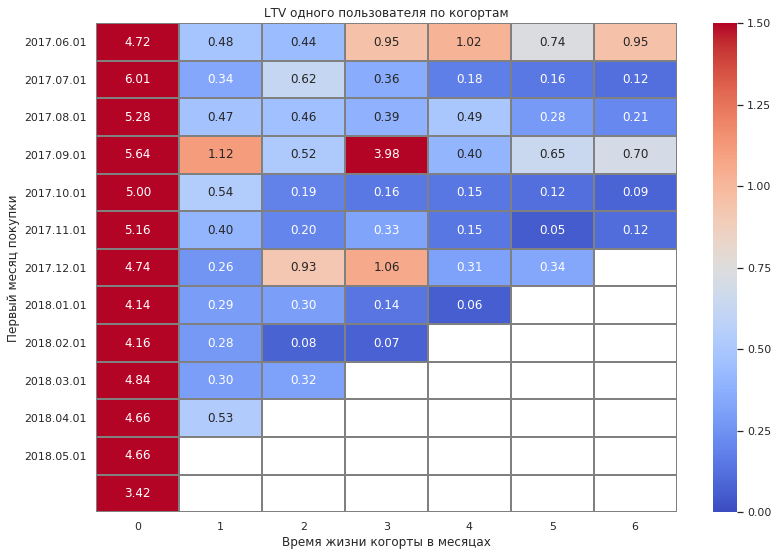

In [63]:
# Построим heatmap
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV одного пользователя по когортам')
plot = sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmin = 0, vmax = 1.5, 
            cmap = 'coolwarm', yticklabels=retention_pivot.index.strftime('%Y.%m.%d'))
plot.set_xlabel('Время жизни когорты в месяцах')
plot.set_ylabel('Первый месяц покупки')
plt.show()

Рассмотрим первые 6 когорт, которые имеют время жизни 7 месяцев и более. Посчитаем для этих когорт LTV за 7 месяцев.

In [64]:
upd_output = report.query('first_order_month <"2017-12-01"')

In [65]:
ltv_output = upd_output.pivot_table(
index = 'first_order_month',
columns = 'age',
values = 'ltv',
aggfunc = 'mean')
ltv_output = ltv_output.cumsum(axis = 1)
ltv_output

age,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,4.724414,5.209743,5.647380,6.602051,7.624582,8.360084,9.310524
2017-07-01,6.010218,6.345429,6.968960,7.327936,7.504727,7.660775,7.780983
2017-08-01,5.276518,5.748511,6.206993,6.598270,7.092321,7.375861,7.586526
2017-09-01,5.644529,6.762115,7.283045,11.258838,11.659396,12.306463,13.008071
2017-10-01,5.003733,5.539495,5.730889,5.888035,6.039594,6.159956,6.244772
2017-11-01,5.154683,5.553916,5.753472,6.078424,6.226437,6.280316,6.395244


In [66]:
ltv_output[6].mean().round(2)

8.39

Видим, что в среднем пользователь приносит 8.39 у.е. за время жизни. Наибольшее количество денег принес пользователь из сентябрьской когорты, на тепловой карте видно, что на 4-й месяц жизни был значительный выброс. Скорее всего была совершена аномально высокая покупка, что и повысило среднее, это скорее исключение из общей тенденции. Тем не менее пользователь сентябрьской когорты даже без этого выброса принес одну из наибольших выручек.

##### Маркетинг

In [67]:
costs

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


* Сколько денег потратили? Всего / на каждый источник / по времени

In [68]:
costs['month'] = costs['dt'].astype('datetime64[M]')

In [69]:
costs_source = costs.groupby('source_id').agg({'costs':'sum'})
costs_time = costs.pivot_table(index = 'month', columns = 'source_id',
                               values = 'costs',
                               aggfunc = 'mean'
                              )

In [70]:
# Всего потратили денег
costs_source.sum()

costs    329131.62
dtype: float64

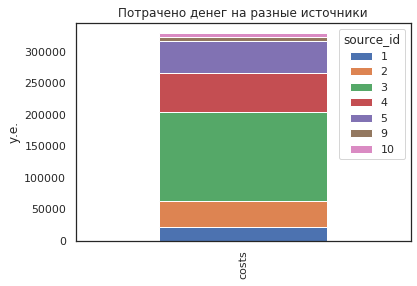

In [71]:
# Денег на каждый источник
plot = costs_source.T.plot(kind = 'bar', stacked = True)
plt.title('Потрачено денег на разные источники')
plot.set_ylabel('у.е.')
plt.show()

In [72]:
costs_source

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


Из таблицы и графика видим, что больше всего потрачено на 3 канал привлечения(141321.63 у.е.), за ним идут 4-й и 5-й.

In [73]:
# Изменение со временем
costs_time

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,37.520333,80.912667,257.721667,117.160000,87.204000,9.507333,10.474000
2017-07-01,34.609032,75.261613,247.560323,113.862258,96.714194,9.759355,10.639355
2017-08-01,30.703548,58.420968,198.178710,103.785806,70.492903,8.030000,7.502258
2017-09-01,50.067000,99.522000,332.118333,173.075333,128.304667,13.854000,15.355667
2017-10-01,74.701613,156.290323,507.652903,207.123871,186.045161,19.658387,20.233548
2017-11-01,81.505333,174.922667,567.511333,179.627333,210.844667,22.772667,26.412000
2017-12-01,75.522581,157.993548,523.210323,247.757097,189.436129,21.225161,20.834194
2018-01-01,70.521935,134.120645,477.702581,188.154516,173.274839,17.650323,19.817742
2018-02-01,78.731429,159.797857,508.162857,203.998571,181.118214,19.696429,17.174286


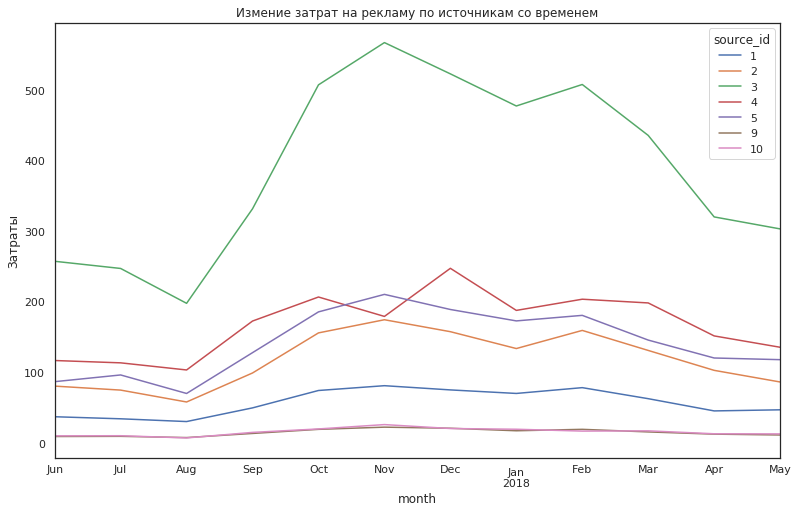

In [74]:
plot = costs_time.plot(figsize=(13,8))
plt.title('Измение затрат на рекламу по источникам со временем')
plot.set_ylabel('Затраты')
plt.show()

Из графика видим, что с начала 2018 года затраты на все источники начали падать. Возможно это связано с оптимизацией расходов, поскольку, например, средний чек в это время начал расти, вероятно совершать покупки стало удобнее, возможно появились какие-либо программы лояльности или бонусы, которые потребовали дополнительных расходов, в результате чего маркетинговый бюджет был урезан.

* Стоимость привлечения одного покупателя из каждого источника

Посчитаем LTV с помощью когортного анализа по источникам.

In [75]:
#Определим источник пользователя по первому переходу
sources = visits.sort_values(by = ['uid','start_ts']).groupby('uid').agg(
    {'source_id':'first'}
)

ltv = orders.merge(sources, on = 'uid') 
ltv['lifetime'] = ((ltv['buy_ts'] - ltv['first_buy']) / 
                   np.timedelta64(1,'M')).round().astype(int)
#ltv

orders_lifetime = ltv.pivot_table(index = 'source_id', 
                                  columns  = 'lifetime',values = 'revenue',aggfunc = 'count').fillna(0)
buyers_lifetime = ltv.pivot_table(index = 'source_id', columns = 'lifetime',values = 'revenue',
                                 aggfunc = 'nunique').fillna(0)
cohort_sizes = ltv.groupby('source_id').agg({'uid':'nunique'}).rename(columns = {'uid':'cohort_size'})
ltv = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue', aggfunc='sum').fillna(0)
ltv = ltv.cumsum(axis = 1)
ltv = ltv.merge(cohort_sizes, on = 'source_id')
ltv = ltv.div(ltv['cohort_size'], axis = 0).drop(columns = 'cohort_size')
ltv 

,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,6.156185,7.150835,7.891156,8.537754,9.029303,9.251083,9.525826,9.866858,10.191256,10.450862,10.557561,10.673508,10.724577
2,6.770593,8.054740,9.717921,11.253637,11.900125,12.484390,12.721418,12.948380,13.171358,13.233560,13.346994,13.380422,13.383802
3,4.477694,4.729283,4.865748,5.008149,5.083093,5.122590,5.147003,5.173669,5.192354,5.197477,5.202699,5.203834,5.204931
4,4.584762,4.738128,4.852278,4.948617,5.068362,5.226563,5.342363,5.391025,5.410340,5.448244,5.502627,5.505380,5.506685
5,4.909883,5.114191,5.469974,6.836748,7.072747,7.246335,7.365203,7.454998,7.515129,7.576270,7.582746,7.592303,7.592558
7,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000
9,3.880901,4.167390,4.408024,4.678888,4.788189,4.935588,5.059127,5.126608,5.244430,5.284972,5.293566,5.293566,5.293566
10,3.164131,3.227434,3.254695,3.302558,3.316576,3.319217,3.332724,3.343348,3.346102,3.348631,3.348631,3.348631,3.348631


Посчитаем метрику САС.

In [76]:
cac = costs.groupby('source_id').agg({'costs':'sum'}).merge(cohort_sizes, on = 'source_id')
cac['cac'] = cac['costs'] / cac['cohort_size']
cac

,costs,cohort_size,cac
source_id,,,
1,20833.27,2899,7.186364
2,42806.04,3506,12.209367
3,141321.63,10473,13.493901
4,61073.60,10296,5.931779
5,51757.10,6931,7.467479
9,5517.49,1088,5.071222
10,5822.49,1329,4.381106


В результате видим, что больше всего тратится на покупателя из 3-го и 2-го источников.

* На сколько окупились расходы

Рассчитаем ROI.

In [77]:
roi = ltv.merge(cac['cac'], on = 'source_id')
roi = roi.div(roi['cac'],axis = 0).drop(columns = 'cac')
roi

,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,0.856648,0.995056,1.098073,1.188049,1.256449,1.287311,1.325542,1.372997,1.418138,1.454263,1.469110,1.485245,1.492351
2,0.554541,0.659718,0.795940,0.921722,0.974672,1.022526,1.041939,1.060528,1.078791,1.083886,1.093177,1.095915,1.096191
3,0.331831,0.350476,0.360589,0.371142,0.376696,0.379623,0.381432,0.383408,0.384793,0.385172,0.385559,0.385643,0.385725
4,0.772915,0.798770,0.818014,0.834255,0.854442,0.881112,0.900634,0.908838,0.912094,0.918484,0.927652,0.928116,0.928336
5,0.657502,0.684862,0.732506,0.915536,0.947140,0.970386,0.986304,0.998329,1.006381,1.014569,1.015436,1.016716,1.016750
9,0.765279,0.821772,0.869223,0.922635,0.944188,0.973254,0.997615,1.010922,1.034155,1.042150,1.043844,1.043844,1.043844
10,0.722222,0.736671,0.742894,0.753818,0.757018,0.757621,0.760704,0.763129,0.763757,0.764335,0.764335,0.764335,0.764335


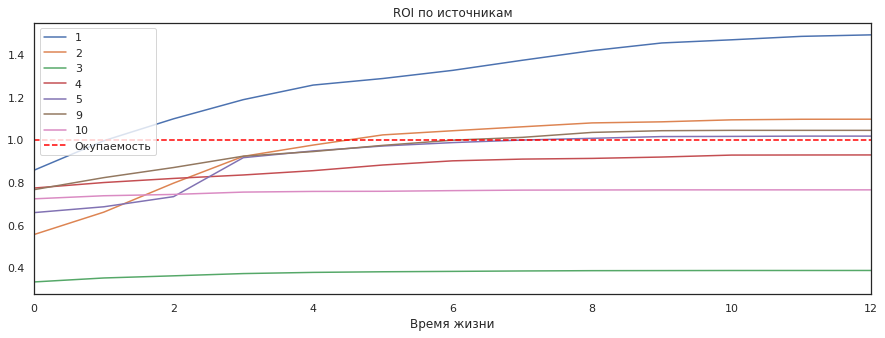

In [78]:
# Строим график ROI
roi.T.plot(figsize = (15,5))
plt.axhline(y = 1, label = 'Окупаемость',color = 'red', linestyle = '--')
plt.title('ROI по источникам')
plt.xlabel('Время жизни')
plt.legend()
plt.show()

Из графика видно, что 1 источник окупился почти сразу. 2,5,9 окупились спустя 6-7 месяцев. Остальные источники не показали окупаемости за весь период.

### Вывод

На этом шаге посчитали важные метрики. 
* Узнали, что значительное число визитов производится с компьютеров(расчитали MAU, WAU, DAU), возможно стоит обратить внимание на каналы привлечения с мобильных устройств, поскольку именно мобильные устройства обеспечивают рост трафика в мировом интернете (https://vc.ru/marketing/106373-digital-trendy-2020-uvelichenie-trafika-usilenie-mobile-otchet-similarweb).
* Выяснили, что пользователи в среднем проводят на сайте недостаточное для покупки время(ASL). Возможно стоит активнее показывать возможность покупки и увеличивать количество развлекательного и/или информационного контента. 
* Существуют проблемы с удержанием пользователей. Лучшие показатели показала первая по времени когорта, далее было существенное падение показателей, при чем чем позднее пользователи были привлечены, тем раньше большинство начинало "отваливаться". Возможно интерфейс со временем усложнился, либо поддержка стала работать хуже, необходимо выяснить причины.
* Был посчитан средний чек и показано его изменение во времени, динамика за 2018 год положительная - средний чек увеличивался.
* Рассчитали метрики LTV, CAC, ROI для оптимизаци маркетинговых затрат.

<a id = 'Шаг_3' > </a> 
# Шаг 3. Общий вывод

Я бы порекомендовал развивать каналы привлечения для мобильных устройств. При этом так же важно не забывать и о пользователях с компьютеров, поскольку они приносят основную выручку. Деньги на дополнительные каналы привлечения можно найти, сократив расходы на не окупающиеся источники. Судя по ROI 3 источник даже не близко не подошел к окупаемости, при этом на него было потрачено больше всего. 
Траты на источники 5,9 так же можно уменьшить, при этом источник 1 показывает себя наиболее перспективным, поэтому бюджет на него можно увеличить, как и бюджет на второй источник(самое высокое значение метрики LTV), с этих каналов стоит привлекать большее количество пользователей.
